# 1. Import Library

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install pySastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 3.2 MB/s eta 0:00:00


In [2]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 2. Load Dataset

In [3]:
import pandas as pd
df = pd.read_csv('/content/ulasan_gojek.csv')

In [4]:
jumlah_ulasan, jumlah_kolom = df.shape

print(jumlah_ulasan)
print(jumlah_kolom)

12000
1


In [5]:
df.head()

,Review
0,terlalu terlalu terlalu... apk yg tidak bisa d...
1,"Aplikasi buat jengkel, pas kepengen beli gofoo..."
2,Sangat lah dibutuhkan untuk tampomas kemanapun...
3,tinggal 2menit lg driver sampe di lokasi tiba-...
4,"Gak usah pasang tarif tarif hemat, soalnya par..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  12000 non-null  object
dtypes: object(1)
memory usage: 93.9+ KB


In [8]:
df_clean = df.dropna()

In [9]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  12000 non-null  object
dtypes: object(1)
memory usage: 93.9+ KB


In [10]:
df_clean = df_clean.drop_duplicates()
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = df_clean.shape

# 3. Preprocessing Text

In [11]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)


    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy","wkwk","wkwkwk"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(words):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    stemmed_words = [stemmer.stem(word) for word in words]

    return stemmed_words


def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [12]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget","gak": "tidak","gk": "tidak",
"indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know",
"ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan",
"ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi",
"aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang",
"ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi",
"bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan",
"beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh",
"blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga",
"bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong",
"buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren",
"calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat",
"cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong",
"cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall",
"cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik",
"dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat",
"dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana",
"drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya",
"emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi",
"gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja",
"gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol",
"githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa",
"gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he",
"helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah",
"humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja",
"jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar",
"jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan",
"kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya",
"kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau",
"kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau",
"klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya",
"komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim",
"kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara",
"latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan",
"lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu",
"lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo","vermuk": "verifikasi muka",
"mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali",
"mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa",
"mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional",
"muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana",
"napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri",
"ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan",
"ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis",
"ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara",
"ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing",
"ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu",
"ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan",
"pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri","bobrok":"tidak layak",
"pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah",
"perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

def fix_slangwords(text):
    words = text.split()
    fix_words = []

    for word in words:
        if word.lower() in slangwords:
            fix_words.append(slangwords[word.lower()])
        else:
            fix_words.append(word)

    fix_text = ' '.join(fix_words)
    return fix_text


In [13]:
df_clean

,Review
0,terlalu terlalu terlalu... apk yg tidak bisa d...
1,"Aplikasi buat jengkel, pas kepengen beli gofoo..."
2,Sangat lah dibutuhkan untuk tampomas kemanapun...
3,tinggal 2menit lg driver sampe di lokasi tiba-...
4,"Gak usah pasang tarif tarif hemat, soalnya par..."
...,...
11995,awalnya sih saya suka pake app ni apalagi pas ...
11996,"Apaan dah aktivitas gak normal, aku malu gagal..."
11997,Kecewa... Dalam satu hari ... 2 kali pesan Goc...
11998,Banyak driver ngebut bawa motor tenyata driver...


In [14]:
df_clean['text_clean'] = df_clean['Review'].apply(cleaningText)

In [15]:
df_clean['text_casefoldingText'] = df_clean['text_clean'].apply(casefoldingText)

In [16]:
df_clean['text_slangwords'] = df_clean['text_casefoldingText'].apply(fix_slangwords)

In [17]:
df_clean['text_tokenizingText'] = df_clean['text_slangwords'].apply(tokenizingText)

In [18]:
df_clean['text_stopword'] = df_clean['text_tokenizingText'].apply(filteringText)

In [19]:
df_clean['text_stemming'] = df_clean['text_stopword'].apply(stemmingText)

In [21]:
df_clean['text_final'] = df_clean['text_stemming'].apply(toSentence)

In [24]:
df_clean.head()

,Review,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_stemming,text_final
0,terlalu terlalu terlalu... apk yg tidak bisa d...,terlalu terlalu terlalu apk yg tidak bisa di p...,terlalu terlalu terlalu apk yg tidak bisa di p...,terlalu terlalu terlalu apk yang tidak bisa di...,"[terlalu, terlalu, terlalu, apk, yang, tidak, ...","[apk, percaya, kuota, cepat, habis, update, bu...","[apk, percaya, kuota, cepat, habis, update, bu...",apk percaya kuota cepat habis update bug hp la...
1,"Aplikasi buat jengkel, pas kepengen beli gofoo...",Aplikasi buat jengkel pas kepengen beli gofood...,aplikasi buat jengkel pas kepengen beli gofood...,aplikasi buat jengkel pas mau beli gofood bisa...,"[aplikasi, buat, jengkel, pas, mau, beli, gofo...","[aplikasi, jengkel, pas, beli, gofood, bisanya...","[aplikasi, jengkel, pas, beli, gofood, bisa, a...",aplikasi jengkel pas beli gofood bisa app eror...
2,Sangat lah dibutuhkan untuk tampomas kemanapun...,Sangat lah dibutuhkan untuk tampomas kemanapun...,sangat lah dibutuhkan untuk tampomas kemanapun...,sangat lah dibutuhkan untuk tampomas kemanapun...,"[sangat, lah, dibutuhkan, untuk, tampomas, kem...","[dibutuhkan, tampomas, kemanapun, berpergian, ...","[butuh, tampomas, mana, pergi, instal, downloa...",butuh tampomas mana pergi instal download suli...
3,tinggal 2menit lg driver sampe di lokasi tiba-...,tinggal menit lg driver sampe di lokasi tibati...,tinggal menit lg driver sampe di lokasi tibati...,tinggal menit lagi driver sampai di lokasi tib...,"[tinggal, menit, lagi, driver, sampai, di, lok...","[tinggal, menit, driver, lokasi, tibatiba, dib...","[tinggal, menit, driver, lokasi, tibatiba, dib...",tinggal menit driver lokasi tibatiba dibatalin...
4,"Gak usah pasang tarif tarif hemat, soalnya par...",Gak usah pasang tarif tarif hemat soalnya para...,gak usah pasang tarif tarif hemat soalnya para...,tidak perlu pasang tarif tarif hemat soalnya p...,"[tidak, perlu, pasang, tarif, tarif, hemat, so...","[pasang, tarif, tarif, hemat, driver, ambil, o...","[pasang, tarif, tarif, hemat, driver, ambil, o...",pasang tarif tarif hemat driver ambil order al...


In [25]:
df_clean.to_csv('clean_data_ulasan.csv', index=False)

# 4. Load Dataset setelah Preprocessing Text

In [26]:
import pandas as pd
clean_df = pd.read_csv('/content/clean_data_ulasan.csv')

In [27]:
jumlah_ulasan, jumlah_kolom = df_clean.shape

print(jumlah_ulasan)
print(jumlah_kolom)

11991
8


# 5. Pelabelan Data

In [28]:
import csv
import requests
from io import StringIO

lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")


lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [29]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text.split():
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word]

    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [31]:
results = df_clean['text_final'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df_clean['polarity_score'] = results[0]
df_clean['polarity'] = results[1]
print(df_clean['polarity'].value_counts())

polarity
positive    7819
negative    3711
neutral      461
Name: count, dtype: int64


# 6. Visualisasi Data

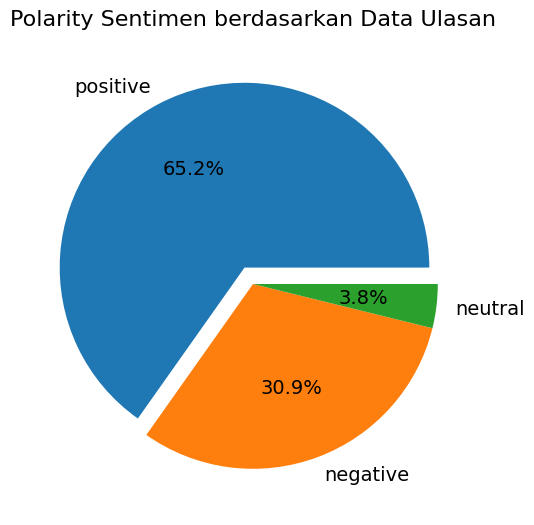

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
sizes = [count for count in df_clean['polarity'].value_counts()]
labels = list(df_clean['polarity'].value_counts().index)
explode = [0.1] + [0] * (len(sizes) - 1)
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Polarity Sentimen berdasarkan Data Ulasan', fontsize=16, pad=20)
plt.show()

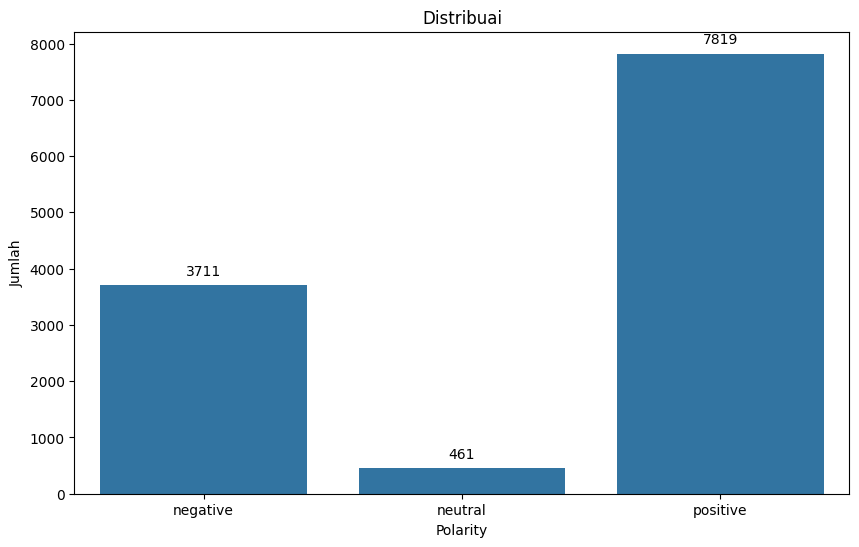

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

plt.figure(figsize=(10, 6))

class_dist_plot = sns.countplot(x='polarity', data=df_clean)
plt.title('Distribuai')
plt.xlabel('Polarity')
plt.ylabel('Jumlah')

for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()


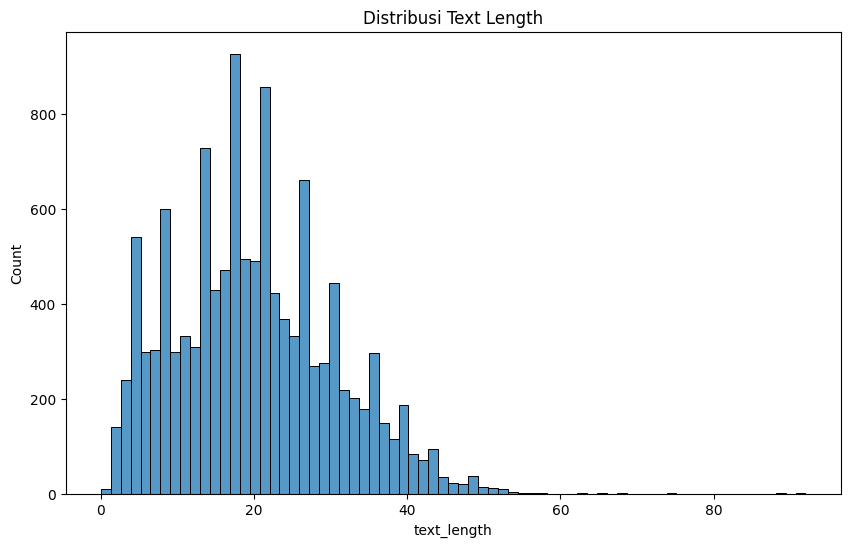

In [40]:
plt.figure(figsize=(10, 6))

df_clean['text_length'] = df_clean['text_final'].apply(lambda x: len(x.split()))
sns.histplot(clean_df['text_length'])
plt.title('Distribusi Text Length')
plt.show()

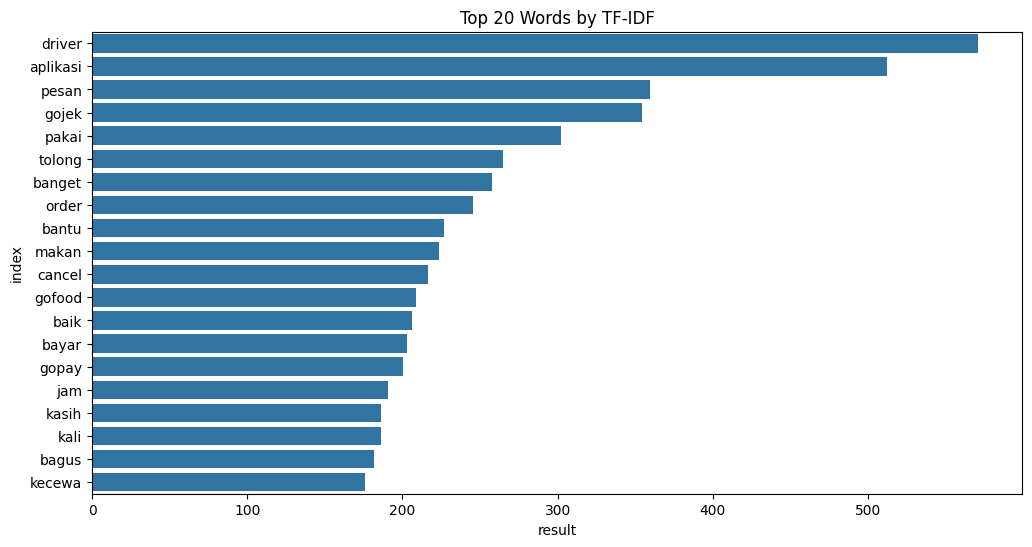

In [145]:
plt.figure(figsize=(12, 6))
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(df_clean['text_final'])
df_tfidf = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names_out())
df_tfidf = df_tfidf.sum().reset_index(name='result')
df_tfidf = df_tfidf.sort_values('result', ascending=False).head(20)
sns.barplot(x='result', y='index', data=df_tfidf)
plt.title('Top 20 Words by TF-IDF')
plt.show()

# 7. Word CLoud

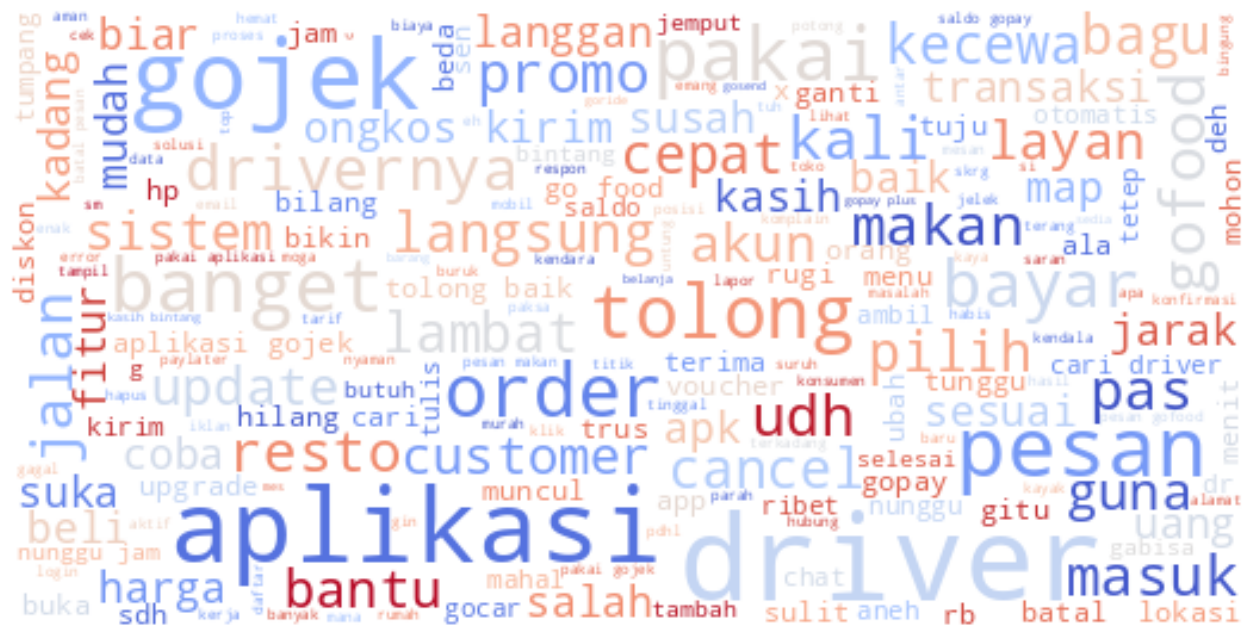

In [36]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
Positive_msg_text = 'positive'.join(df_clean['text_final'])

Positive_msg_cloud = WordCloud(width =520,
                                height =260,
                                stopwords = STOPWORDS,
                                max_font_size = 50,
                                background_color = "white",
                                colormap = 'coolwarm').generate(Positive_msg_text)

plt.figure(figsize=(16,10))
plt.imshow(Positive_msg_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

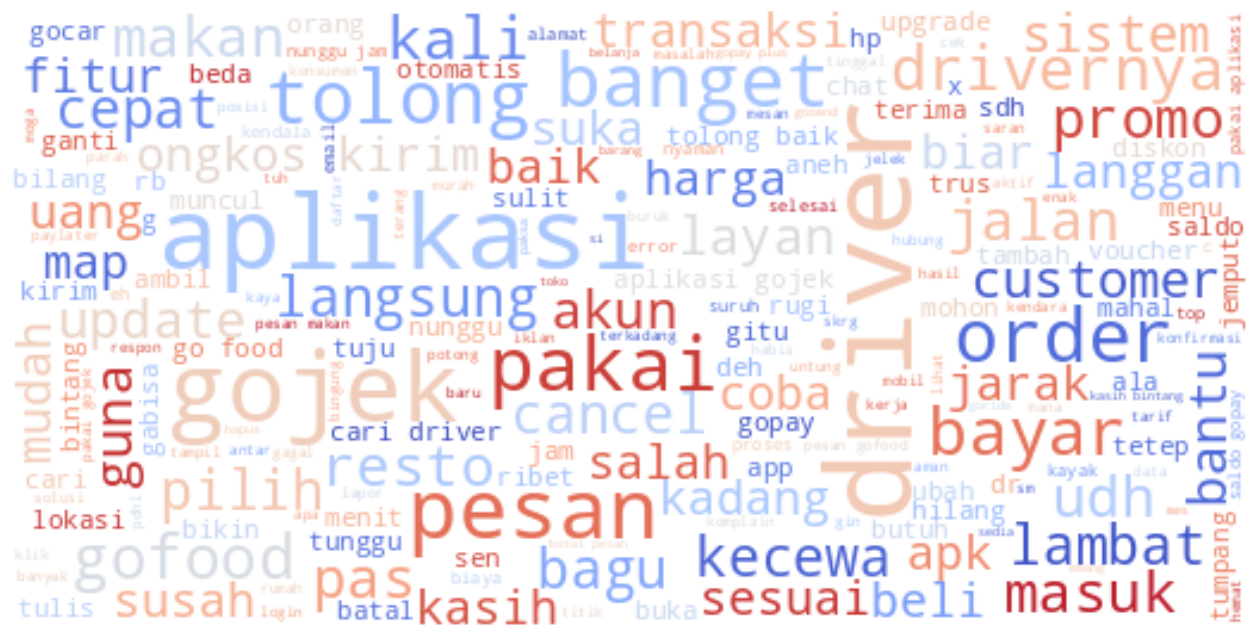

In [33]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Negative_msg_text = 'negative'.join(df_clean['text_final'])

Negative_msg_cloud = WordCloud(width =520,
                                height =260,
                                stopwords = STOPWORDS,
                                max_font_size = 50,
                                background_color = "white",
                                colormap = 'coolwarm').generate(Negative_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(Negative_msg_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

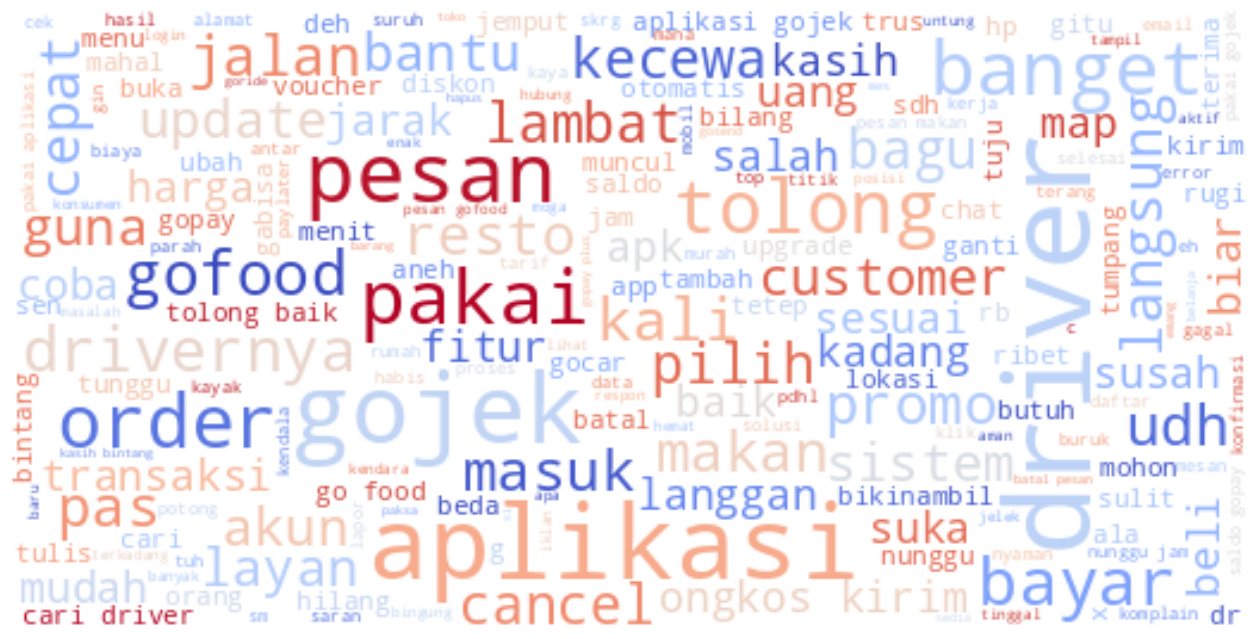

In [34]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Neutral_msg_text = 'neutral'.join(df_clean['text_final'])

Neutral_msg_cloud = WordCloud(width =520,
                                height =260,
                                stopwords = STOPWORDS,
                                max_font_size = 50,
                                background_color = "white",
                                colormap = 'coolwarm').generate(Neutral_msg_text)

plt.figure(figsize=(16,10))
plt.imshow(Neutral_msg_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, precision_score

In [130]:
X = df_clean['text_final']
y = df_clean['polarity']

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=10, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)

In [132]:
df_tfidf_features = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

df_tfidf_features

,abai,abang,ac,acara,accord,account,ada,adain,adakan,adik,...,way,whatsapp,wifi,wilayah,wktu,worth,xl,yaaa,yah,youtube
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.290739,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.237312,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
11987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
11988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
11989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [133]:
print(len(tfidf.get_feature_names_out()))

1702


In [134]:
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2

x_train_tfidf = np.array(df_tfidf_features)
y_train_tfidf = np.array(y)

selector_tfidf = SelectKBest(chi2, k=1000)
text_tfidf_selected = selector_tfidf.fit_transform(x_train_tfidf, y_train_tfidf)

# untuk reduced features
print('Feature Number Asli', x_train_tfidf.shape[1])
print('Feature Number Pengurangan', text_tfidf_selected.shape[1])

Feature Number Asli 1702
Feature Number Pengurangan 1000


In [135]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

oversampler_tfidf = SMOTE(random_state=2)
X_resampled_tfidf, y_resampled_tfidf = oversampler_tfidf.fit_resample(text_tfidf_selected, y_train_tfidf)

In [136]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_resampled_tfidf, y_resampled_tfidf, test_size=0.1, random_state=42)

print('Jumlah X_train dataset : ', X_train_tfidf.shape)
print('Jumlah y_train dataset : ', y_train_tfidf.shape)

print('Jumlah X_test dataset : ', X_test_tfidf.shape)
print('Jumlah y_test dataset : ', y_test_tfidf.shape)

Jumlah X_train dataset :  (21111, 1000)
Jumlah y_train dataset :  (21111,)
Jumlah X_test dataset :  (2346, 1000)
Jumlah y_test dataset :  (2346,)


In [137]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(1000,)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [138]:
ann_model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [139]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.93 and logs.get('val_accuracy') > 0.93:
            print("\nAkurasi pelatihan dan validasi telah mencapai >93%! Pelatihan dihentikan.")
            self.model.stop_training = True
callbacks = myCallback()
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [140]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()

Y_train_tfidf_encoded = label_encoder.fit_transform(y_train_tfidf)
Y_train_tfidf_one_hot = to_categorical(Y_train_tfidf_encoded)

Y_test_tfidf_encoded = label_encoder.transform(y_test_tfidf)
Y_test_tfidf_one_hot = to_categorical(Y_test_tfidf_encoded)

print("Mapping nilai encode:")
for label, encoded_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{label}: {encoded_value}")


Mapping nilai encode:
negative: 0
neutral: 1
positive: 2


In [141]:
history = ann_model.fit(X_train_tfidf,
                 Y_train_tfidf_one_hot,
                 validation_data=(X_test_tfidf, Y_test_tfidf_one_hot),
                 epochs=100,
                 batch_size=32,
                 callbacks = [callbacks,early_stop])

Epoch 1/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5588 - loss: 1.0432 - val_accuracy: 0.8606 - val_loss: 0.4094
Epoch 2/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8381 - loss: 0.4288 - val_accuracy: 0.9118 - val_loss: 0.2477
Epoch 3/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8965 - loss: 0.2857 - val_accuracy: 0.9395 - val_loss: 0.1764
Epoch 4/100
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9234 - loss: 0.2177 - val_accuracy: 0.9454 - val_loss: 0.1621
Epoch 5/100
647/660 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9357 - loss: 0.1847
Akurasi pelatihan dan validasi telah mencapai >93%! Pelatihan dihentikan.
660/660 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9355 - loss: 0.1850 - val_accuracy: 0.9518 - val_loss: 0.1357


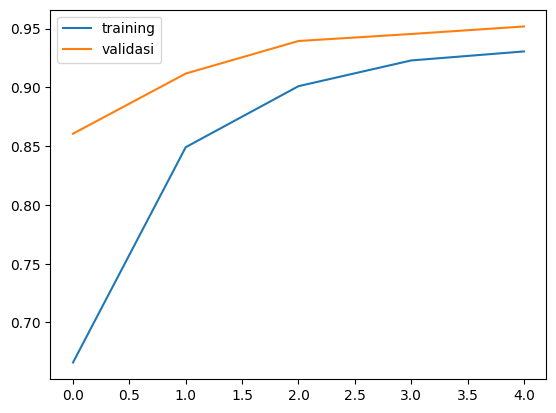

In [143]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validasi')
plt.legend()
plt.show()

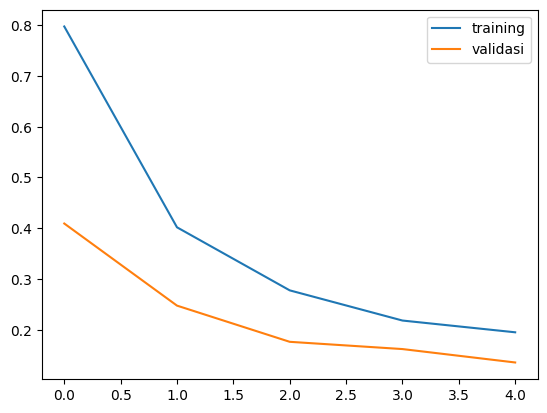

In [144]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validasi')
plt.legend()
plt.show()

# 8. Random Forest Model TF-IDF Cross Validation

## Ekstraksi Fitur TF-IDF

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=10, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)

In [58]:
df_tfidf_features = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

df_tfidf_features

,abai,abang,ac,acara,accord,account,ada,adain,adakan,adik,...,way,whatsapp,wifi,wilayah,wktu,worth,xl,yaaa,yah,youtube
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.290739,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.237312,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
11987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
11988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
11989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [59]:
print(len(tfidf.get_feature_names_out()))

1702


# 8. Feature Selection

In [114]:
import numpy as np

x_train_tfidf = np.array(df_tfidf_features)
y_train_tfidf = np.array(y)

from sklearn.feature_selection import SelectKBest, chi2
select_tfidf = SelectKBest(chi2, k=1000)
text_tfidf_selected = select_tfidf.fit_transform(x_train_tfidf, y_train_tfidf)

print('Feature Number Asli', x_train_tfidf.shape[1])
print('Feature Number Pengurangan', text_tfidf_selected.shape[1])

Feature Number Asli 1702
Feature Number Pengurangan 1000


# 9. SMOTE Oversampling

In [62]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

oversampler_tfidf = SMOTE(random_state=2)
X_resampled_tfidf, y_resampled_tfidf = oversampler_tfidf.fit_resample(text_tfidf_selected, y_train_tfidf)

# 10. Melatih Model Random Forest dengan Pembagian Cross Validation

In [63]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200)


In [68]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

SKF = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_scores_train = []
accuracy_scores_test = []
confusion_matrixes = []

for train_index, test_index in SKF.split(X_resampled_tfidf, y_resampled_tfidf):
    X_train_fold, X_test_fold = X_resampled_tfidf[train_index], X_resampled_tfidf[test_index]
    y_train_fold, y_test_fold = y_resampled_tfidf[train_index], y_resampled_tfidf[test_index]

    random_forest.fit(X_train_fold, y_train_fold)
    y_predict_train = random_forest.predict(X_train_fold)
    acc_train_score = accuracy_score(y_train_fold, y_predict_train)
    accuracy_scores_train.append(acc_train_score)

    y_predict_test = random_forest.predict(X_test_fold)

    confusionn_matrix = confusion_matrix(y_test_fold, y_predict_test)
    confusion_matrixes.append(confusionn_matrix)

    acc_test_score = accuracy_score(y_test_fold, y_predict_test)
    accuracy_scores_test.append(acc_test_score)

for i, (confusionn_matrix, acc_train, acc_test) in enumerate(zip(confusion_matrixes, accuracy_scores_train, accuracy_scores_test), 1):
    print(f'Fold {i}:')
    print(f'Accuracy Train: {acc_train}')
    print(f'Accuracy Test: {acc_test}')
    print(f'Confusion Matrix:\n{confusionn_matrix}')

mean_acc_train_score = np.mean(accuracy_scores_train)
mean_acc_test_score = np.mean(accuracy_scores_test)

print(f'Mean Accuracy Train: {mean_acc_train_score}')
print(f'Mean Accuracy Test: {mean_acc_test_score}')

Fold 1:
Accuracy Train: 0.9994315759556629
Accuracy Test: 0.9092071611253197
Confusion Matrix:
[[660  24  98]
 [  3 776   3]
 [ 77   8 697]]
Fold 2:
Accuracy Train: 0.9993842072853015
Accuracy Test: 0.9156010230179028
Confusion Matrix:
[[667  23  92]
 [  4 774   4]
 [ 70   5 707]]
Fold 3:
Accuracy Train: 0.9994315759556629
Accuracy Test: 0.9202898550724637
Confusion Matrix:
[[664  23  95]
 [  1 776   5]
 [ 63   0 719]]
Fold 4:
Accuracy Train: 0.9994789446260244
Accuracy Test: 0.9151747655583973
Confusion Matrix:
[[660  25  97]
 [  0 781   1]
 [ 69   7 706]]
Fold 5:
Accuracy Train: 0.9994789446260244
Accuracy Test: 0.9164535379369139
Confusion Matrix:
[[676  31  75]
 [  0 782   0]
 [ 82   8 692]]
Fold 6:
Accuracy Train: 0.9994315759556629
Accuracy Test: 0.9006820119352089
Confusion Matrix:
[[659  22 101]
 [  0 779   3]
 [ 93  14 675]]
Fold 7:
Accuracy Train: 0.9994315759556629
Accuracy Test: 0.9104859335038363
Confusion Matrix:
[[650  30 102]
 [  0 781   1]
 [ 74   3 705]]
Fold 8:
Accur

In [76]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score, classification_report

SKF = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

confusion_matrixes = []
accuracy_scores = []
balanced_accuracy_scores = []

for train_index, test_index in SKF.split(X_resampled_tfidf, y_resampled_tfidf):
  X_train_fold, X_test_fold = X_resampled_tfidf[train_index], X_resampled_tfidf[test_index]
  y_train_fold, y_test_fold = y_resampled_tfidf[train_index], y_resampled_tfidf[test_index]

  random_forest.fit(X_train_fold, y_train_fold)

  y_predict_fold = random_forest.predict(X_test_fold)

  confusionn_matrix = confusion_matrix(y_test_fold, y_predict_fold)
  confusion_matrixes.append(confusionn_matrix)

  acc_score = accuracy_score(y_test_fold, y_predict_fold)
  ball_acc_score = balanced_accuracy_score(y_test_fold, y_predict_fold)
  accuracy_scores.append(acc_score)
  balanced_accuracy_scores.append(ball_acc_score)

for i, (confusionn_matrix, acc_score, ball_acc_score) in enumerate(zip(confusion_matrixes, accuracy_scores, balanced_accuracy_scores), 1):
  print(f'Fold {i}:')
  print(f'Accuracy: {acc_score}')
  print(f'Confusion Matrix:\n{confusionn_matrix}')

mean_acc_score = np.mean(accuracy_scores)
print(f'Mean Accuracy CV: {mean_acc_score}')

Fold 1:
Accuracy: 0.9087809036658141
Confusion Matrix:
[[657  25 100]
 [  3 777   2]
 [ 76   8 698]]
Fold 2:
Accuracy: 0.9096334185848253
Confusion Matrix:
[[662  21  99]
 [  3 775   4]
 [ 80   5 697]]
Fold 3:
Accuracy: 0.9232736572890026
Confusion Matrix:
[[667  24  91]
 [  1 778   3]
 [ 59   2 721]]
Fold 4:
Accuracy: 0.9202898550724637
Confusion Matrix:
[[665  20  97]
 [  0 781   1]
 [ 62   7 713]]
Fold 5:
Accuracy: 0.9143222506393862
Confusion Matrix:
[[675  32  75]
 [  0 782   0]
 [ 83  11 688]]
Fold 6:
Accuracy: 0.9062233589087809
Confusion Matrix:
[[664  23  95]
 [  0 781   1]
 [ 88  13 681]]
Fold 7:
Accuracy: 0.907928388746803
Confusion Matrix:
[[645  32 105]
 [  0 779   3]
 [ 74   2 706]]
Fold 8:
Accuracy: 0.9176972281449893
Confusion Matrix:
[[687  16  79]
 [  5 773   4]
 [ 78  11 692]]
Fold 9:
Accuracy: 0.9185501066098081
Confusion Matrix:
[[680  19  83]
 [  1 779   1]
 [ 75  12 695]]
Fold 10:
Accuracy: 0.9142857142857143
Confusion Matrix:
[[663  20  98]
 [  1 779   2]
 [ 72 

# 11. RNN Model GRU dengan Tokenizer Keras

## Oversampling Class Imbalance

In [77]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
X_resampled_gru, y_resampled_gru = oversampler.fit_resample(X.values.reshape(-1, 1), y)

In [78]:
df_resampled  = pd.DataFrame(X_resampled_gru, columns=['text'])
df_resampled['polarity'] = y_resampled_gru

## Data Splitting

In [79]:
df_resampled['word_lenght'] = df_resampled['text'].str.split()
df_resampled['word_lenght'] = df_resampled['word_lenght'].str.len()
df_resampled.dropna(inplace=True)

In [80]:
df_resampled.head(10)

,text,polarity,word_lenght
0,apk percaya kuota cepat habis update bug hp la...,negative,24
1,aplikasi jengkel pas beli gofood bisa app eror...,negative,23
2,butuh tampomas mana pergi instal download suli...,neutral,13
3,tinggal menit driver lokasi tibatiba dibatalin...,positive,34
4,pasang tarif tarif hemat driver ambil order al...,positive,25
5,update aplikasi susah pesan rumah stasiun paka...,positive,24
6,tentu gocar terap atur bluebirdkurang bagus dr...,positive,30
7,saran aplikasi tolong ongkos kirim ongkos jala...,positive,30
8,guna kali kecewa aplikasi gojek gocar kadang s...,positive,37
9,pesan gosend jam pesan driver gerakgerak hubun...,negative,35


In [81]:
df_resampled['word_lenght'].sort_values(ascending=False)

,word_lenght
5794,92
8611,89
8663,89
9097,75
8748,68
...,...
21296,0
21417,0
19287,0
18412,0


In [83]:
from sklearn.model_selection import train_test_split

X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(df_resampled['text'], df_resampled['polarity'], test_size=0.1, random_state=42)

# 12. Pre-processing Teks dengan Tokenizer Keras

In [86]:
!pip install tensorflow
!pip install keras
from tensorflow.keras.preprocessing.text import Tokenizer

max_len = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
vocab_size = 2000

tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_gru)

In [87]:
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

16667

In [88]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequences_train_gru = tokenizer.texts_to_sequences(X_train_gru)
padded_train_gru = pad_sequences(sequences_train_gru, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [89]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequences_validation = tokenizer.texts_to_sequences(X_test_gru)
padded_validation = pad_sequences(sequences_validation, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [90]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()

y_train_gru_encoded = label_encoder.fit_transform(y_train_gru)
y_train_gru_one_hot = to_categorical(y_train_gru_encoded)

y_test_gru_encoded = label_encoder.transform(y_test_gru)
y_test_gru_one_hot = to_categorical(y_test_gru_encoded)

print("Mapping Nilai Encode:")
for label, encoded_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
  print(f"{label}: {encoded_value}")

Mapping Nilai Encode:
negative: 0
neutral: 1
positive: 2


In [91]:
print('Train tensor:', padded_train_gru.shape)
print('Test tensor:', padded_validation.shape)

Train tensor: (21111, 200)
Test tensor: (2346, 200)


# 13. GRU

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

embedding_dim = 128
drop_value = 0.2

gru_model = Sequential()
gru_model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length=max_len))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(GlobalAveragePooling1D())
gru_model.add(Dense(24, activation='relu'))
gru_model.add(Dropout(drop_value))
gru_model.add(Dense(3, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [96]:
gru_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [97]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.93 and logs.get('val_accuracy') > 0.93:
            print("\nAkurasi train dan test telah mencapai >93%! Train dihentikan.")
            self.model.stop_training = True
callbacks = myCallback()
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [101]:
history1 = gru_model.fit(padded_train_gru,
                    y_train_gru_one_hot,
                    epochs = 50,
                    batch_size = 32,
                    validation_data = (padded_validation, y_test_gru_one_hot),
                    callbacks = [early_stop, callbacks],
                    verbose=2)

Epoch 1/50
660/660 - 96s - 146ms/step - accuracy: 0.5064 - loss: 0.9512 - val_accuracy: 0.7229 - val_loss: 0.6471
Epoch 2/50
660/660 - 92s - 139ms/step - accuracy: 0.8848 - loss: 0.3214 - val_accuracy: 0.9344 - val_loss: 0.1795
Epoch 3/50

Akurasi train dan test telah mencapai >93%! Train dihentikan.
660/660 - 142s - 215ms/step - accuracy: 0.9554 - loss: 0.1294 - val_accuracy: 0.9557 - val_loss: 0.1232


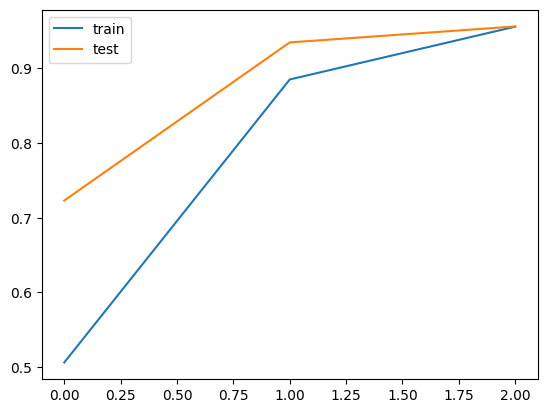

In [103]:
import matplotlib.pyplot as plt

plt.plot(history1.history['accuracy'], label='train')
plt.plot(history1.history['val_accuracy'], label='test')
plt.legend()
plt.show()

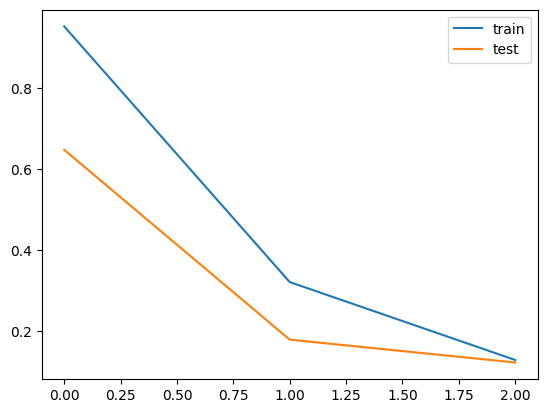

In [104]:
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.show()

# 14. Perbandingan 3 Percobaan Test dari 3 Model, 2 Ekstrasi Fitur, 2 Data Split yang Berbeda.

In [113]:
import numpy as np

# Model GRU
gru_train = gru_model.evaluate(padded_train_gru, np.asarray(y_train_gru_one_hot), verbose=2, batch_size=32)
gru_test = gru_model.evaluate(padded_validation, np.asarray(y_test_gru_one_hot), verbose=2, batch_size=32)

# Model ANN
ann_train = ann_model.evaluate(X_train_tfidf, np.asarray(Y_train_tfidf_one_hot), verbose=2, batch_size=32)
ann_test = ann_model.evaluate(X_test_tfidf, np.asarray(Y_test_tfidf_one_hot), verbose=2, batch_size=32)

mean_train_acc_score = np.mean(accuracy_scores_train)
mean_test_acc_score = np.mean(accuracy_score_test)

print()
print(f'Accuracy Train Mean Random Forest : {mean_train_acc_score*100:0.2f} Mean Test Accuracy RF : {mean_test_acc_score*100:0.2f}')
print(f'Accuracy Train GRU : {gru_train[1]*100:0.2f} Test Accuracy GRU : {gru_test[1]*100:0.2f}')
print(f'Accuracy Train ANN : {ann_train[1]*100:0.2f} Test Accuracy ANN : {ann_test[1]*100:0.2f}')

660/660 - 18s - 28ms/step - accuracy: 0.9791 - loss: 0.0648
74/74 - 2s - 30ms/step - accuracy: 0.9557 - loss: 0.1232
660/660 - 1s - 2ms/step - accuracy: 0.9781 - loss: 0.0826
74/74 - 0s - 2ms/step - accuracy: 0.9390 - loss: 0.1703

Accuracy Train Mean Random Forest : 99.94 Mean Test Accuracy RF : 91.43
Accuracy Train GRU : 97.91 Test Accuracy GRU : 95.57
Accuracy Train ANN : 97.81 Test Accuracy ANN : 93.90


# 15. Testing

In [116]:
new_kalimat = input("Masukkan kalimat baru: ")

new_kalimat_cleaned = cleaningText(new_kalimat)
new_kalimat_casefolded = casefoldingText(new_kalimat_cleaned)
new_kalimat_slangfixed = fix_slangwords(new_kalimat_casefolded)
new_kalimat_tokenized = tokenizingText(new_kalimat_slangfixed)
new_kalimat_filtered = filteringText(new_kalimat_tokenized)
new_kalimat_akhir = toSentence(new_kalimat_filtered)

X_new_kalimat = tfidf.transform([new_kalimat_akhir])

X_new_kalimat = pd.DataFrame(X_new_kalimat.toarray(), columns=tfidf.get_feature_names_out())

new = np.array(X_new_kalimat)

selector = select_tfidf.transform(new)

new_prediksi = random_forest.predict(selector)

predicted_index = np.argmax(new_prediksi)

if predicted_index == 0:
    print("Sentimen kalimat baru adalah baru adalah POSITIVE.")
elif predicted_index == 1:
    print("Sentimen kalimat baru adalah NEUTRAL.")
else:
    print("Sentimen kalimat baru adalah NEGATIVE.")


Masukkan kalimat baru: aman naik gojek
Sentimen kalimat baru adalah baru adalah POSITIVE.


Kesimpulan :

1.   Preprocessing Data

*   Data ulasan diambil dari Google Play Store Gojek sebanyak 12.000 baris. Dibersihkan dengan menghapus duplikat data menghasilkan 11.991 data unik.
*   Proses preprocessing data meliputi pembersihan teks yaitu menghapus karakter tidak penting, angka dan juga tanda baca. Kemudian case folding yaitu mengubah teks menjadi huruf kecil. Perbaikan slangwords, tokenisasi, penghapusan stopwords dan stemming data untuk mendapatkan teks yang lebih konsisten.

2.   Pelabelan Sentimen

*   Sentimen dianalisis menggunakan leksikon positif dan negatif dalam bahasa Indonesia.
*   Hasil analisis menunjukkan mayoritas ulasan positif sebanyak 7.819 ulasan (65.2%), negatif sebanyak 3.711 ulasan (30.9%) dan netral 461 ulasan (3.9%).
*   Ulasan positif lebih mendominasi, hal ini menunjukkan kepuasan pelanggan terhadap layanan Gojek, meskipun masih ada sejumlah ulasan negatif yang perlu diperhatikan lagi.

3.   Train dan Test Set    

*   Ukuran train set yang digunakan 80%.
*   Ukuran test set yang digunakan 20%.










